## Suavización Exponencial Simple (SES)


Uno de los enfoques más comunes y efectivos para el análisis de series de tiempo es la **suavización exponencial simple (SES)**. Este método es particularmente útil cuando los datos presentan una tendencia suave o fluctuaciones menores, y no contienen un patrón de estacionalidad o tendencia clara. La suavización exponencial simple se basa en un concepto simple: asignar un peso decreciente a los datos pasados, lo que significa que los valores más recientes tienen una mayor influencia en la predicción futura que los valores anteriores.

La SES puede describirse matemáticamente como:

$$
y_{t+1} = \lambda y_t + (1 - \lambda) y_{t-1}
$$

Donde:
- $(y_{t+1}) $ es el valor predicho.
- $y_t$  es el valor observado más reciente.
- $ \lambda $ es el factor de suavización, con un valor entre 0 y 1, que determina el peso de los valores pasados.

Un valor de $\lambda$ cercano a 1 dará mayor peso a los datos más recientes, mientras que un valor cercano a 0 asignará más importancia a los valores anteriores. En nuestro análisis, hemos utilizado una $\lambda = 0.4$ lo que proporciona un balance entre el pasado reciente y los valores más antiguos.

En este trabajo, hemos aplicado el método de **suavización exponencial simple** para analizar la potencia eléctrica generada por las microturbinas en diferentes experimentos. 


In [1]:
# Importar las librerías necesarias
import pandas as pd
import os
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt

# Ruta a la carpeta donde se encuentran los archivos de entrenamiento
train_folder = '/Users/josejavier-yenifer/Documents/Serie de Tiempo/Bono 1/train'

# Nombres de los archivos CSV
train_files = ['ex_1.csv', 'ex_9.csv', 'ex_20.csv', 'ex_21.csv', 'ex_23.csv', 'ex_24.csv']

# Cargar los archivos CSV en variables con prefijo 'df_' y nombre del archivo (sin .csv)
dfs = []
for file in train_files:
    file_name = file.split('.')[0]  # Eliminar la extensión .csv
    file_path = os.path.join(train_folder, file)
    
    # Crear una variable dinámica con el nombre df_<nombre_archivo>
    globals()[f"df_{file_name}"] = pd.read_csv(file_path)

    # Guardar el DataFrame para mostrar luego
    dfs.append((file_name, globals()[f"df_{file_name}"]))


<>:84: SyntaxWarning: invalid escape sequence '\l'
<>:84: SyntaxWarning: invalid escape sequence '\l'
/var/folders/pc/g1c35bc91zbfqvk3gwrrc_5c0000gn/T/ipykernel_45067/3409707953.py:84: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(df['time'][:train_end], smooth_train, color='red', linestyle='--', label=f'Suavización SES Entrenamiento ($\lambda={lambda_}$)')


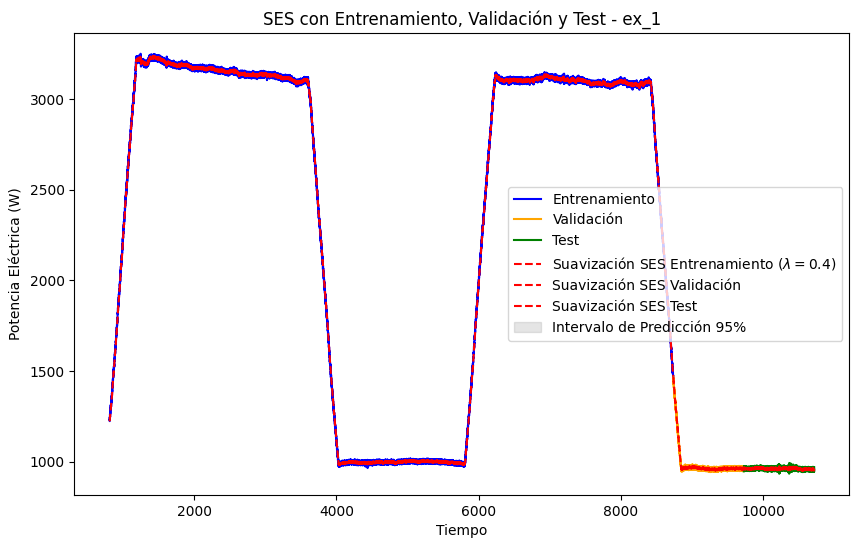

/var/folders/pc/g1c35bc91zbfqvk3gwrrc_5c0000gn/T/ipykernel_45067/3409707953.py:118: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, temp_df], ignore_index=True)


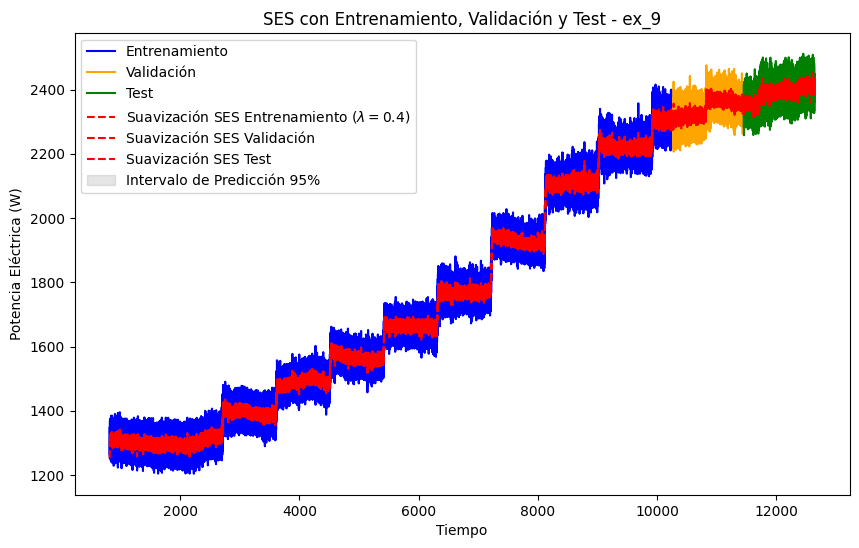

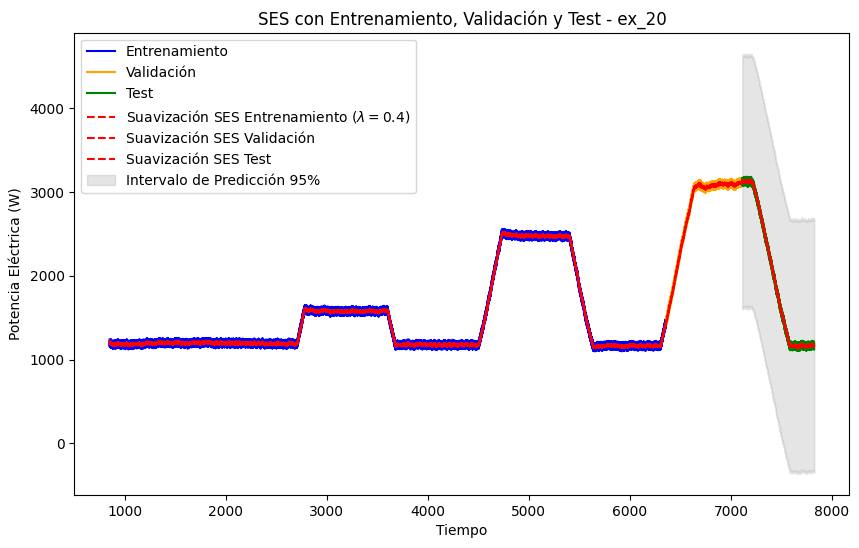

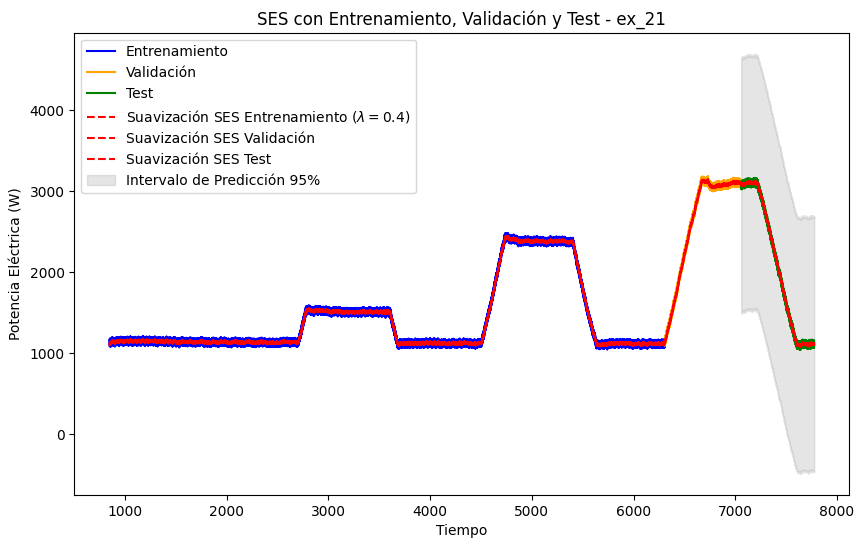

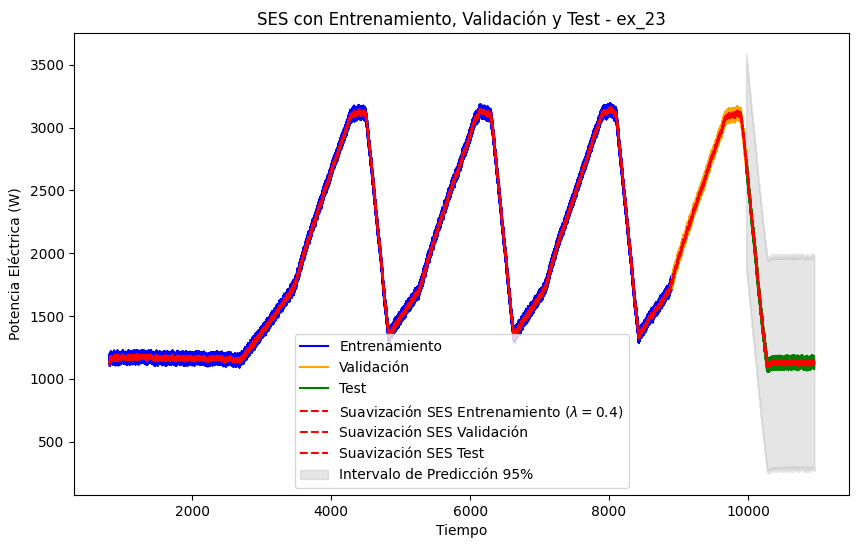

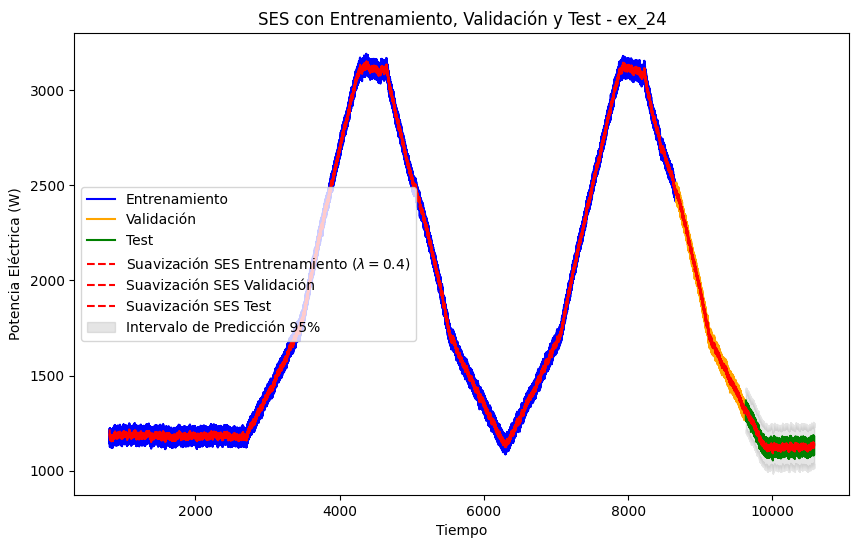

In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Función de suavización exponencial simple
def firstsmooth(y, lambda_, start=None):
    ytilde = y.copy()
    if start is None:
        start = y[0]
    ytilde[0] = lambda_ * y[0] + (1 - lambda_) * start
    for i in range(1, len(y)):
        ytilde[i] = lambda_ * y[i] + (1 - lambda_) * ytilde[i - 1]
    return ytilde

# Función de métricas de precisión
def measacc_fs(y_true, y_pred):
    T = len(y_true)
    prederr = y_true - y_pred
    SSE = sum(prederr**2)
    MAPE = 100 * sum(abs(prederr / y_true)) / T
    MAD = sum(abs(prederr)) / T
    MSD = sum(prederr**2) / T
    return {"SSE": SSE, "MAPE": MAPE, "MAD": MAD, "MSD": MSD}

# Función para calcular el MAE
def calculate_mae(y_true, y_pred):
    MAE = sum(abs(y_true - y_pred)) / len(y_true)
    return MAE

# Función para calcular el intervalo de predicción
def prediction_interval(y_true, alpha=0.05):
    std_err = np.std(y_true)  # Desviación estándar de los errores
    z_score = 1.96  # Para un nivel de confianza del 95%
    interval_size = z_score * std_err
    return interval_size

# Parámetro lambda (tasa de suavización)
lambda_ = 0.4

# Lista de DataFrames y nombres para iterar
dataframes = [df_ex_1, df_ex_9, df_ex_20, df_ex_21, df_ex_23, df_ex_24]
names = ['ex_1', 'ex_9', 'ex_20', 'ex_21', 'ex_23', 'ex_24']

# División en entrenamiento, validación y test
train_size = 0.8  # 80% para entrenamiento
val_size = 0.1    # 10% para validación
test_size = 0.1   # 10% para test

# Crear un DataFrame para almacenar todas las métricas
metrics_df = pd.DataFrame(columns=['Experimento', 'SSE_Train', 'MAPE_Train', 'MAD_Train', 'MSD_Train',
                                   'SSE_Val', 'MAPE_Val', 'MAD_Val', 'MSD_Val', 'MAE_Test'])

# Aplicar suavización exponencial simple manual a cada serie de tiempo
for df, name in zip(dataframes, names):
    # Definir la longitud de cada conjunto
    n = len(df)
    train_end = int(train_size * n)
    val_end = train_end + int(val_size * n)
    
    # Dividir en conjuntos de entrenamiento, validación y test
    train_data = df['el_power'][:train_end]
    val_data = df['el_power'][train_end:val_end]
    test_data = df['el_power'][val_end:]
    
    # Aplicar la suavización en los datos de entrenamiento
    smooth_train = firstsmooth(train_data.values, lambda_)
    
    # Suavización para el conjunto de validación usando el último valor del entrenamiento
    smooth_val = firstsmooth(val_data.values, lambda_, start=smooth_train[-1])
    
    # Suavización para el conjunto de test usando el último valor del conjunto de validación
    smooth_test = firstsmooth(test_data.values, lambda_, start=smooth_val[-1])
    
    # Intervalo de predicción
    pred_interval = prediction_interval(smooth_test)
    
    # Graficar la serie original con tres colores para los conjuntos de datos
    plt.figure(figsize=(10, 6))
    plt.plot(df['time'][:train_end], df['el_power'][:train_end], color='blue', label='Entrenamiento')
    plt.plot(df['time'][train_end:val_end], df['el_power'][train_end:val_end], color='orange', label='Validación')
    plt.plot(df['time'][val_end:], df['el_power'][val_end:], color='green', label='Test')
    
    # Graficar la suavización en los tres conjuntos
    plt.plot(df['time'][:train_end], smooth_train, color='red', linestyle='--', label=f'Suavización SES Entrenamiento ($\lambda={lambda_}$)')
    plt.plot(df['time'][train_end:val_end], smooth_val, color='red', linestyle='--', label='Suavización SES Validación')
    plt.plot(df['time'][val_end:], smooth_test, color='red', linestyle='--', label='Suavización SES Test')
    
    # Graficar el intervalo de predicción para el test
    plt.fill_between(df['time'][val_end:], smooth_test - pred_interval, smooth_test + pred_interval, color='gray', alpha=0.2, label='Intervalo de Predicción 95%')
    
    # Configuración del gráfico
    plt.title(f'SES con Entrenamiento, Validación y Test - {name}')
    plt.xlabel('Tiempo')
    plt.ylabel('Potencia Eléctrica (W)')
    plt.legend()
    plt.show()

    # Calcular las métricas de precisión en el conjunto de entrenamiento
    metrics_train = measacc_fs(train_data.values, smooth_train)
    
    # Calcular las métricas de precisión en el conjunto de validación
    metrics_val = measacc_fs(val_data.values, smooth_val)
    
    # Calcular solo el MAE (MAD) en el conjunto de test
    mae_test = calculate_mae(test_data.values, smooth_test)
    
    # Crear un DataFrame temporal con las métricas del experimento actual
    temp_df = pd.DataFrame({
        'Experimento': [name],
        'SSE_Train': [metrics_train['SSE']], 'MAPE_Train': [metrics_train['MAPE']],
        'MAD_Train': [metrics_train['MAD']], 'MSD_Train': [metrics_train['MSD']],
        'SSE_Val': [metrics_val['SSE']], 'MAPE_Val': [metrics_val['MAPE']],
        'MAD_Val': [metrics_val['MAD']], 'MSD_Val': [metrics_val['MSD']],
        'MAE_Test': [mae_test]
    })
    
    # Usar pd.concat() para agregar las filas al DataFrame de métricas
    metrics_df = pd.concat([metrics_df, temp_df], ignore_index=True)



1. **Ex_1 (Primera gráfica)**:
   - En esta serie, los datos de potencia eléctrica muestran dos grandes picos seguidos por una caída abrupta.
   - El modelo de Suavización Exponencial Simple (SES) con \(\lambda = 0.4\) sigue de manera eficiente los picos y las caídas del conjunto de entrenamiento.
   - Sin embargo, al final, durante la fase de validación y prueba, el modelo parece estabilizarse en un valor constante, lo que podría indicar una falta de adaptación a los cambios abruptos.

2. **Ex_9 (Segunda gráfica)**:
   - Aquí, la serie de tiempo muestra un crecimiento escalonado y sostenido en la potencia eléctrica.
   - El SES sigue bien las fluctuaciones en la fase de entrenamiento, pero nuevamente, en la validación y prueba, tiende a sobrestimar al suavizar excesivamente el crecimiento de los últimos puntos.
   - Este comportamiento indica que el SES puede no captar bien los aumentos constantes en la tendencia, lo que puede ser un área de mejora con modelos más avanzados.

3. **Ex_20 y Ex_21 (Tercera y cuarta gráfica)**:
   - Ambas series muestran un patrón repetitivo de picos y caídas abruptas.
   - El SES capta bien las transiciones en las fases de entrenamiento, aunque suaviza ligeramente en exceso los picos.
   - Durante la fase de validación y prueba, el SES tiene problemas para anticipar correctamente los picos y caídas, manteniendo una predicción más constante.

4. **Ex_23 y Ex_24 (Quinta y sexta gráfica)**:
   - Estas series presentan un comportamiento cíclico, con múltiples picos.
   - El SES sigue de manera adecuada los picos del conjunto de entrenamiento.
   - En la fase de prueba, el SES tiende a suavizar demasiado, y aunque predice el comportamiento general, no sigue con precisión los picos de los datos reales.



In [ ]:
# Mostrar el DataFrame con las métricas
metrics_df

,Experimento,SSE_Train,MAPE_Train,MAD_Train,MSD_Train,SSE_Val,MAPE_Val,MAD_Val,MSD_Val,MAE_Test
0,ex_1,6.278002e+05,0.383271,7.963499,79.107882,5.179615e+04,0.664518,6.562480,52.213863,9.403936
1,ex_9,1.801089e+07,2.623333,42.964697,1904.906807,2.471974e+06,1.911820,44.725072,2093.119806,66.902444
2,ex_20,5.846009e+06,2.456404,33.222419,1125.097908,7.689526e+05,1.269902,33.710223,1184.826762,1206.667652
3,ex_21,5.676552e+06,2.519509,32.731631,1092.485081,7.793841e+05,1.404732,33.823424,1200.899943,1059.963855
4,ex_23,8.463306e+06,2.007281,33.549776,1151.470207,1.069381e+06,1.333398,33.740317,1164.903516,1376.228552
5,ex_24,8.213038e+06,2.017377,33.495498,1137.855150,1.027053e+06,1.945376,33.493879,1138.640129,156.017828




El análisis de las métricas muestra una clara variación en el rendimiento de la suavización exponencial simple (SES) entre los diferentes experimentos:

- **SSE (Suma de los Errores Cuadrados)**: Los conjuntos de entrenamiento muestran valores más altos en algunos experimentos, como en `ex_9`, lo que sugiere una mayor discrepancia entre las predicciones y los valores reales. En general, la validación tiene menores SSE, pero experimentos como `ex_9` y `ex_24` siguen siendo significativamente elevados.

- **MAPE (Error Porcentual Absoluto Medio)**: Se observa que los errores porcentuales en el conjunto de validación son bajos en comparación con los de entrenamiento, lo cual puede sugerir que el modelo se ajusta bien a los datos de validación en algunos casos, como `ex_1`. Sin embargo, los experimentos `ex_9` y `ex_24` tienen un MAPE considerablemente más alto, indicando un rendimiento más pobre.

- **MAD (Desviación Absoluta Media)**: El error absoluto muestra una consistencia similar entre los conjuntos de entrenamiento y validación, excepto en `ex_9`, donde los valores de error son elevados.

- **MSD (Desviación Media Cuadrática)**: En los experimentos `ex_9`, `ex_20`, y `ex_21`, la MSD es particularmente alta, lo que indica una mayor variabilidad en los errores de predicción.

- **MAE (Error Absoluto Medio) en el conjunto de Test**: Los valores de MAE para `ex_1` son relativamente bajos (9.4), lo que muestra un buen desempeño en ese conjunto de datos. Por otro lado, experimentos como `ex_20` y `ex_21` tienen valores muy altos de MAE en el test, lo que indica que las predicciones durante el test no fueron precisas.

